In [4]:
import pandas as pd # pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# from sklearn import impute 
from  scipy.stats import skew, kurtosis, shapiro,zscore
import datetime


plt.rc('axes', linewidth=2)
plt.rc('axes', labelsize= 16)
plt.rc('axes',titlesize = 18)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('figure',figsize=(10,8))

def figure_layout(figsize=(10,8),titel="",xlabel="",ylabel="",fontsize_titel=18,fontsize_axis=16,fontsize_legend=14,fontsize_ticks=16):
    plt.figure(figsize=figsize)
    ax1 = plt.gca()
    plt.rc('legend',fontsize=fontsize_legend)
    plt.title(titel, fontsize=fontsize_titel, fontweight = 'bold')
    plt.grid(True)
    plt.xlabel(xlabel, fontsize=fontsize_axis)
    plt.ylabel(ylabel, fontsize=fontsize_axis)
    for tick in ax1.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_ticks)
    #         tick.label1.set_fontweight('bold')
    for tick in ax1.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize_ticks)
    #     tick.label1.set_fontweight('bold')
    
    return ax1

fullYeardata = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\FullYeardata.csv",parse_dates=['date'], index_col='date') 
amount_measurements = fullYeardata.shape[0]
amount_meters = fullYeardata.shape[1]

# Imputing missing data

In [2]:
# Estimate the missing data based on previous and future observations
def estimated_mean_signal(test):
    # subsitude if necessary the first of january or the last day of december (general) then
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        meanOfSerie = test[col_ID].mean()
        for date in missing_index:
            if date.dayofyear == 1 or date.dayofyear == 365:
            # if date.day == 1 or date.day == 31:
                estimation = meanOfSerie
                test.loc[date,col_ID] = estimation
    
    # subsitude the rest of the days
    for col_ID in test.columns:
        missing_index = test.loc[pd.isna(test[col_ID]), :].index
        for date in missing_index:
            n = 0
            next_measure_index = date + datetime.timedelta(days= 1)
            next_measure_value = test.loc[next_measure_index,col_ID]
            
            previous_measure_index = date + datetime.timedelta(days= -1)
            previous_measure_value = test.loc[previous_measure_index,col_ID]

            while np.isnan(next_measure_value) or np.isnan(previous_measure_value):
                n += 1
                            
                if np.isnan(next_measure_value) and np.isnan(previous_measure_value):

                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]
                
                elif np.isnan(next_measure_value):
                    next_measure_index = date + datetime.timedelta(days= n + 1)
                    next_measure_value = test.loc[next_measure_index,col_ID]

                elif np.isnan(previous_measure_value):
                    previous_measure_index = date + datetime.timedelta(days= -1*(n + 1))
                    previous_measure_value = test.loc[next_measure_index,col_ID]

                else:
                    raise Exception("Should have been excepted by one of the previous cases.")
                

            estimation = (next_measure_value + previous_measure_value)/2
            test.loc[date,col_ID] = estimation

In [3]:
fydc = fullYeardata.copy(deep=True)
fydc.isna().sum()

meter_2979    1344
meter_2980    1584
meter_2981    1344
meter_2982    1392
meter_2983    1392
              ... 
meter_3244    1392
meter_3245    2400
meter_3246    1344
meter_3247    1296
meter_3248    1392
Length: 270, dtype: int64

In [4]:
# estimation and subsitution of the missing values.
estimated_mean_signal(fydc)
fydc.isna().sum().sum()

0

In [5]:
fydc.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\no_missing_values.csv")

# Removing outliers in the yearly consumption.

In [6]:
fydc_sum = fydc.sum(axis=0)
print("This is the mean %s and this is the std %s." % (fydc_sum.mean(),fydc_sum.std()))
fydc_sum

This is the mean 3430.352233897716 and this is the std 2124.1121685635235.


meter_2979    4880.281250
meter_2980    4388.654125
meter_2981    4655.625750
meter_2982    3911.509250
meter_2983    3080.892000
                 ...     
meter_3244    1952.248250
meter_3245    2098.086248
meter_3246    2113.929000
meter_3247    5546.302750
meter_3248    4706.339750
Length: 270, dtype: float64

In [7]:
zscoreArray = zscore(fydc_sum,nan_policy="omit")
print("The original amount of meters: %s" % len(zscoreArray))
# remove the meters that have an outlier consumption. (> 3xstd)
# Assume that the yearly consumption is a normal distributed.
fydc_new = fydc.loc[:,list(abs(zscoreArray) < 3)]
print("The new amount of meters after outlier removal: %s" % fydc_new.shape[1])


The original amount of meters: 270
The new amount of meters after outlier removal: 264


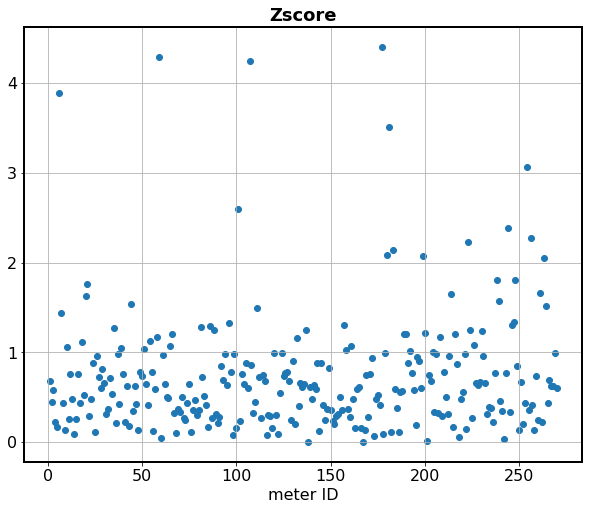

In [8]:
axes = figure_layout((10,8),"Zscore","meter ID","",18,16,14,16)
axes.scatter(np.arange(1,len(zscoreArray)+1), abs(zscoreArray))
# axes.legend(["Full dataset"])
plt.show()

# Removing time-series that have days with zero consumption

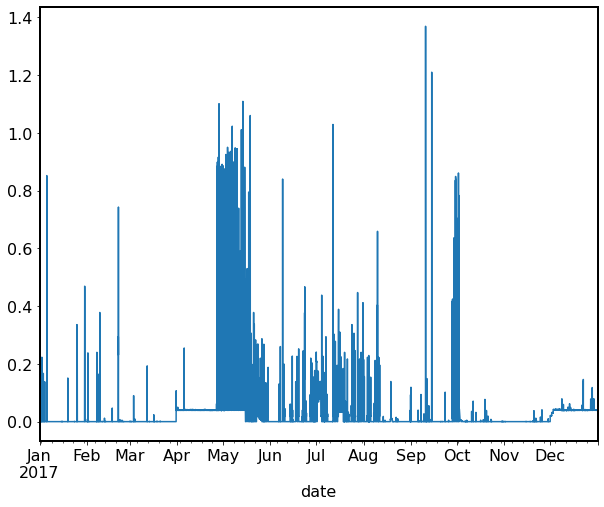

In [9]:
fyd_no_nan = fydc_new.copy(deep=True)
fyd_no_nan['meter_2985'].plot()

In [10]:
fydc_new_daily = fyd_no_nan.resample('D',axis=0).sum()
amountZeroDays = dict()

for col in fydc_new_daily.columns:
    count = 0
    for row in fydc_new_daily.index:
        value = fydc_new_daily.loc[row,col]
        if value == 0:
            count = count + 1
    amountZeroDays[col] = count

In [11]:
originalLength = fyd_no_nan.shape[1]
for key in amountZeroDays:
    if amountZeroDays[key] > 0:
        fyd_no_nan.drop(key,axis=1,inplace=True)
        print("Meter that is dropped: %s."%(key))
newLength = fyd_no_nan.shape[1]
print("Amount of meters original: %s.\nAfter removal: %s."%(originalLength,newLength))


Meter that is dropped: meter_2985.
Meter that is dropped: meter_3049.
Meter that is dropped: meter_3064.
Meter that is dropped: meter_3140.
Meter that is dropped: meter_3175.
Meter that is dropped: meter_3186.
Meter that is dropped: meter_3194.
Meter that is dropped: meter_3225.
Meter that is dropped: meter_3231.
Amount of meters original: 264.
After removal: 255.


In [12]:
fyd_no_nan.shape

(17520, 255)

# Normalizing time-series
Normalizing is done by looking at the minimum and maximum in the time-serie.

In [19]:
fyd_no_nan.head()

,meter_2979,meter_2980,meter_2981,meter_2982,meter_2983,meter_2986,meter_2987,meter_2988,meter_2989,meter_2990,...,meter_3239,meter_3240,meter_3241,meter_3242,meter_3243,meter_3244,meter_3245,meter_3246,meter_3247,meter_3248
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.175,0.280,0.523,0.034,0.185,0.208,0.321,0.393,0.195,0.391,...,0.219,0.015,0.320,0.012,0.155,0.011,0.015,0.222,0.195,0.023
2017-01-01 00:30:00,0.217,1.844,2.285,0.032,0.205,0.259,0.162,0.432,0.157,0.334,...,2.707,2.879,0.325,1.476,0.153,1.089,1.523,0.276,2.881,2.307
2017-01-01 01:00:00,0.175,1.849,1.880,0.045,0.176,0.242,0.062,0.404,0.176,0.238,...,2.752,2.895,0.194,0.237,0.161,0.014,0.105,0.097,1.765,1.403
2017-01-01 01:30:00,0.206,0.577,2.223,0.333,0.159,0.158,0.060,0.410,0.178,0.166,...,2.369,2.038,0.284,0.274,0.206,0.204,0.296,0.058,1.391,1.471
2017-01-01 02:00:00,0.187,0.371,1.020,1.638,0.585,0.063,0.026,0.438,0.165,0.066,...,1.583,1.635,0.278,0.015,0.168,0.015,0.067,0.045,1.609,1.421


In [17]:
fyc_update = fyd_no_nan.copy(deep=True)
from sklearn.preprocessing import MinMaxScaler

In [208]:
# Every time serie is individually normalized.

In [18]:
meter_min_max = dict()
for col in fyc_update.columns:
    ser = fyc_update[col]
    values = ser.values
    values = values.reshape((len(values), 1))
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(values)
    print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
    addList = [scaler.data_min_,scaler.data_max_]
    meter_min_max[col] = addList
    normalized = scaler.transform(values)
    fyc_update[col] = normalized
fyc_update.head()

Min: 0.000000, Max: 3.566000
Min: 0.015000, Max: 3.137000
Min: 0.016000, Max: 3.021000
Min: 0.002000, Max: 2.347000
Min: 0.010000, Max: 2.063000
Min: 0.000000, Max: 2.282000
Min: 0.000000, Max: 2.305000
Min: 0.000000, Max: 3.409000
Min: 0.029000, Max: 2.624000
Min: 0.019000, Max: 2.239000
Min: 0.000000, Max: 4.570000
Min: 0.014000, Max: 1.284000
Min: 0.000000, Max: 2.339000
Min: 0.002000, Max: 1.041000
Min: 0.001000, Max: 3.108000
Min: 0.000000, Max: 0.684000
Min: 0.010000, Max: 2.513000
Min: 0.010000, Max: 3.644000
Min: 0.000000, Max: 5.296000
Min: 0.023000, Max: 2.622000
Min: 0.005000, Max: 2.502000
Min: 0.044000, Max: 2.433500
Min: 0.000000, Max: 2.023000
Min: 0.000000, Max: 1.758000
Min: 0.011000, Max: 1.704000
Min: 0.016000, Max: 1.589000
Min: 0.000000, Max: 1.180000
Min: 0.029000, Max: 1.518000
Min: 0.000000, Max: 2.245000
Min: 0.006000, Max: 3.335000
Min: 0.021000, Max: 1.451000
Min: 0.008000, Max: 1.966000
Min: 0.000000, Max: 1.935000
Min: 0.000000, Max: 3.814000
Min: 0.000000,

,meter_2979,meter_2980,meter_2981,meter_2982,meter_2983,meter_2986,meter_2987,meter_2988,meter_2989,meter_2990,...,meter_3239,meter_3240,meter_3241,meter_3242,meter_3243,meter_3244,meter_3245,meter_3246,meter_3247,meter_3248
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.049075,0.084881,0.168719,0.013646,0.085241,0.091148,0.139262,0.115283,0.063969,0.167568,...,0.043915,0.004657,0.059059,0.003364,0.058824,0.005676,0.004439,0.145996,0.053735,0.000289
2017-01-01 00:30:00,0.060852,0.585842,0.755075,0.012793,0.094983,0.113497,0.070282,0.126723,0.049326,0.141892,...,0.625088,0.957418,0.060011,0.413793,0.057843,0.561920,0.960685,0.184266,0.933814,0.659833
2017-01-01 01:00:00,0.049075,0.587444,0.620300,0.018337,0.080857,0.106047,0.026898,0.118510,0.056647,0.098649,...,0.635599,0.962741,0.035054,0.066442,0.061765,0.007224,0.061509,0.057406,0.568152,0.398787
2017-01-01 01:30:00,0.057768,0.180013,0.734443,0.141151,0.072577,0.069238,0.026030,0.120270,0.057418,0.066216,...,0.546134,0.677645,0.052200,0.076815,0.083824,0.105263,0.182625,0.029766,0.445609,0.418423
2017-01-01 02:00:00,0.052440,0.114029,0.334110,0.697655,0.280078,0.027607,0.011280,0.128483,0.052408,0.021171,...,0.362532,0.543580,0.051057,0.004205,0.065196,0.007740,0.037413,0.020553,0.517038,0.403985


# Removing time-series with a fundamental change in the data.

In [175]:
fyc_norm = fyc_update.copy(deep=True)

In [176]:
rolling_df = pd.DataFrame(index=fyc_norm.index)

In [177]:
# By default the result of the window is set to the right edge of the window. Therefore, the first week is calculated by a variable size and should be removed.
# By default a window is used that are all evenly weighted.
for col in fyc_norm.columns:
    rolling_mean = fyc_norm[col].rolling(window='7D').mean()
    rolling_df[col] = rolling_mean
for rowName in rolling_df.index[0:336]:
    rolling_df.drop(rowName,inplace=True)

In [178]:
difference_min_max = rolling_df.max(axis=0) - rolling_df.min(axis=0)

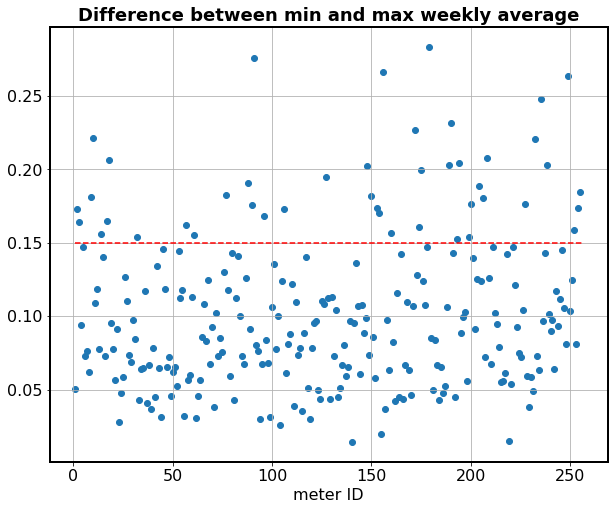

In [179]:
axes = figure_layout((10,8),"Difference between min and max weekly average","meter ID","",18,16,14,16)
plt.hlines(y=0.15,xmin=1,xmax=len(difference_min_max)+1,colors='r',linestyles='dashed')
axes.scatter(np.arange(1,len(difference_min_max)+1), difference_min_max)
# axes.legend(["Full dataset"])

plt.show()

In [180]:
print("original amount of meters: %s."%fyc_norm.shape[1])
fyc_norm_new = fyc_norm.loc[:,list(np.array(difference_min_max) <= 0.15)]
print("New amount of meters: %s."%fyc_norm_new.shape[1])

original amount of meters: 255.
New amount of meters: 211.


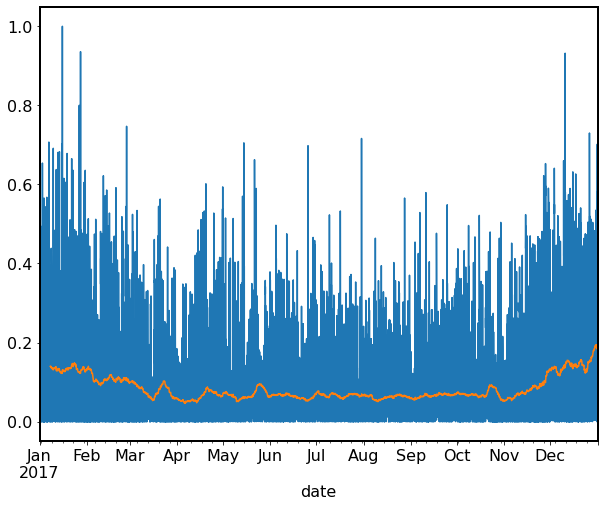

In [188]:
# serie with the biggest difference
new_difference_min_max = difference_min_max[difference_min_max <=0.15]
max_diff = new_difference_min_max.idxmax()
fyc_norm[max_diff].plot()
rolling_df[max_diff].plot()

# The average time-serie of the remaining houses.

In [257]:
fyc_final = fyc_norm_new.copy(deep=True)

In [265]:
av_fyc_final_a = fyc_final.mean(axis=1)
# again normalize after averaging
values = av_fyc_final_a.values
values = values.reshape((len(values), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
av_fyc_final = scaler.transform(values)
av_fyc_final = np.array(av_fyc_final).squeeze()
av_fyc_final = pd.Series(data=av_fyc_final,index=av_fyc_final_a.index)
print(av_fyc_final)

Min: 0.027560, Max: 0.180332
date
2017-01-01 00:00:00    0.197956
2017-01-01 00:30:00    0.324095
2017-01-01 01:00:00    0.222895
2017-01-01 01:30:00    0.204648
2017-01-01 02:00:00    0.199865
                         ...   
2017-12-31 21:30:00    0.389986
2017-12-31 22:00:00    0.396742
2017-12-31 22:30:00    0.326528
2017-12-31 23:00:00    0.274797
2017-12-31 23:30:00    0.267028
Length: 17520, dtype: float64


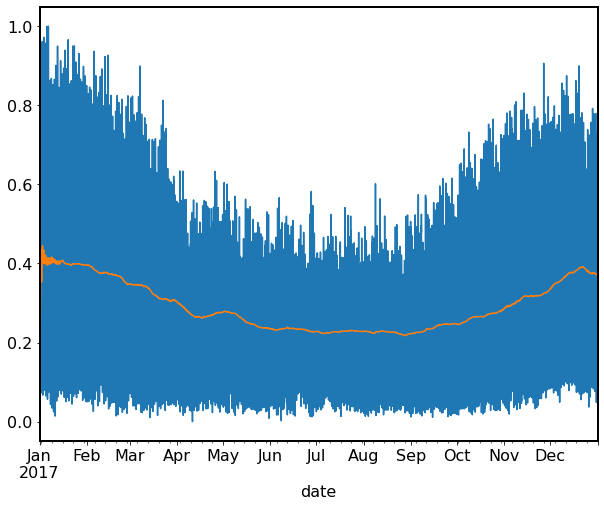

In [266]:
fyc_final["av_final"] = av_fyc_final
rolling_mean = av_fyc_final.rolling(window='14D').mean()
av_fyc_final.plot()
rolling_mean.plot()
plt.show()

In [2]:
fyc_final.to_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv")

NameError: name 'fyc_final' is not defined

In [6]:
fyc_final = pd.read_csv("D:\Onedrive\Leuven\Final project\data\WrittenData\\fyc_final.csv",parse_dates=['date'], index_col='date') 

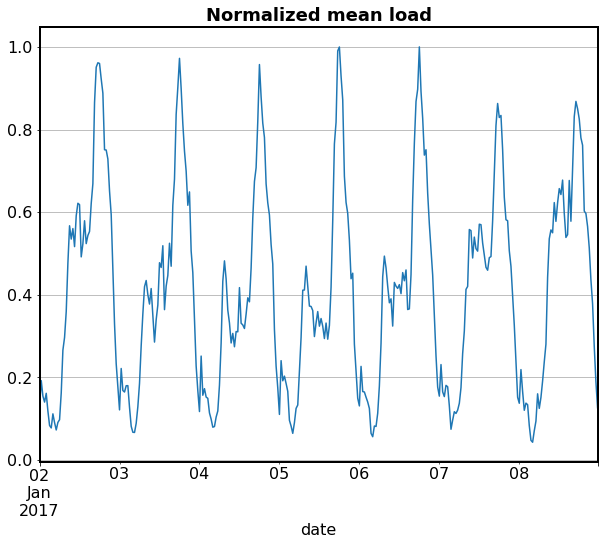

In [7]:
axes1 = figure_layout(titel="Normalized mean load",xlabel="date")
fyc_final.loc[list(fyc_final.index.weekofyear == 1),"av_final"].plot(grid=True, ax = axes1)

# Daily and weekly filters
The daily and weekly filter as described in 'Short term load forecasting with seasonal
decomposition using evolution for parameter tuning'. 


In [9]:
obs = np.zeros(48)
obs_index = fyc_final.index[fyc_final.index.dayofyear == 1]
for day in range(1,365+1,1):
    temp = fyc_final.loc[list(fyc_final.index.dayofyear == day),"av_final"]
    data = temp.values
    obs = obs + data
obs = obs/365
day_filter = pd.Series(data=obs,index=obs_index)

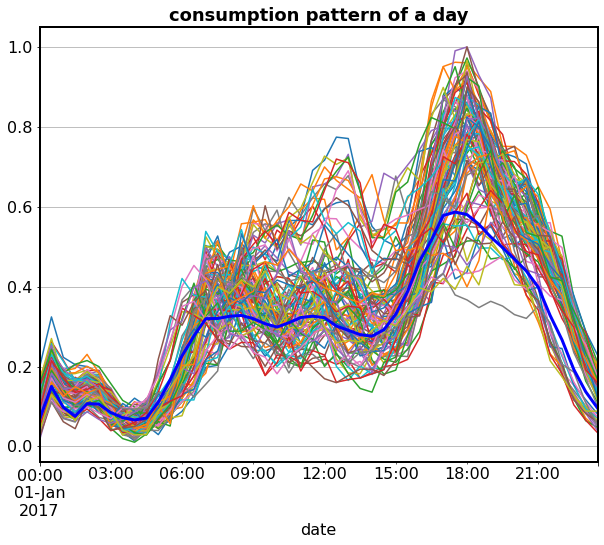

In [10]:
# The typical consumption of one day
axes1 = figure_layout(titel="consumption pattern of a day",xlabel="date")
for i in range(1,100):
    temp = fyc_final.loc[list(fyc_final.index.dayofyear == i),"av_final"]
    values = temp.values
    temp = pd.Series(data=values,index=obs_index)
    temp.plot(ax=axes1,grid=True)
day_filter.plot(ax=axes1,grid=True,lw=3.0,style='b')
plt.show()

In [11]:
# The typical consumption of one week
obs = np.zeros(336)
obs_index = fyc_final.index[fyc_final.index.weekofyear == 1]
for week in range(1,52,1):
    temp = fyc_final.loc[list(fyc_final.index.weekofyear == week),"av_final"]
    data = temp.values
    obs = obs + data
obs = obs/51
week_filter = pd.Series(data=obs,index=obs_index)

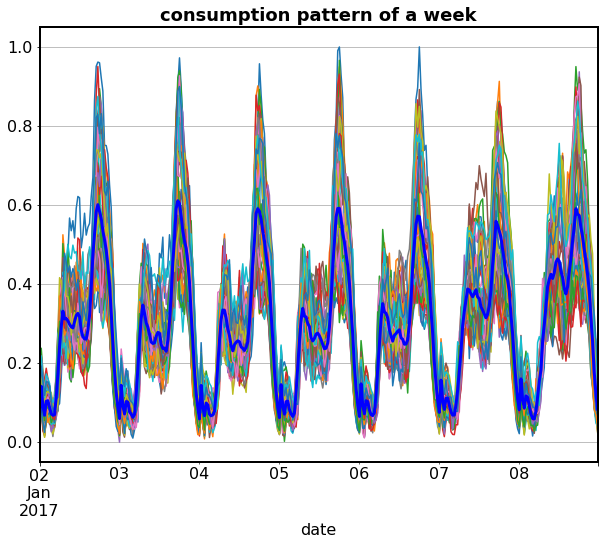

In [12]:
# The typical consumption of one day
axes2 = figure_layout(titel="consumption pattern of a week",xlabel="date")
for i in range(1,52):
    temp = fyc_final.loc[list(fyc_final.index.weekofyear == i),"av_final"]
    values = temp.values
    temp = pd.Series(data=values,index=obs_index)
    temp.plot(ax=axes2,grid=True)
week_filter.plot(ax=axes2,grid=True,lw=3.0,style='b')

plt.show()

# Influence of temperature

In [109]:
fyc_final_new = fyc_final.copy(deep=True)

In [15]:
originalData = pd.read_csv("D:\Onedrive\Leuven\Final project\data\consumption.csv") 

In [91]:
originalData.head()

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,...,2017-12-31 19:00:00,2017-12-31 19:30:00,2017-12-31 20:00:00,2017-12-31 20:30:00,2017-12-31 21:00:00,2017-12-31 21:30:00,2017-12-31 22:00:00,2017-12-31 22:30:00,2017-12-31 23:00:00,2017-12-31 23:30:00
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052,0.091,0.083,0.082,0.090,0.074,0.092,0.076,0.055,0.036
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.402,0.639,0.537,0.834,0.868,0.394,0.073,0.077,0.049,0.048
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.110,0.123,0.012,0.034,0.006,0.027,0.001,0.044,0.004,0.035
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.118,0.096,0.135,0.041,0.018,0.057,0.018,0.038,0.040,0.014
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.022,0.010,0.036,0.006,0.024,0.014,0.028,0.006,0.024,0.025


In [106]:
av_temperature = pd.read_csv("D:\Onedrive\Leuven\Final project\data\weather-avg.csv") 

In [108]:
av_temperature.set_index(av_temperature["meter_id"],inplace=True)
av_temperature.drop("meter_id")
av_temperature.head()

KeyError: "['meter_id'] not found in axis"

In [87]:
daysin2017 = pd.date_range(start='2017-1-1 00:00:00',end='2017-12-31 00:00:00',freq='D')
daysin2017

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [89]:
originalID = []
for name in fyc_final_new.columns[0:-1]:
    number = name.split("_")
    number = number[1]
    number = int(number)
    originalID.append(originalData["meter_id"].iloc[number])

In [92]:
av_temperature.loc(originalID[0])

ValueError: No axis named 0x0d65536896a29a82ce55a81d592c3a9c6c0f797b for object type <class 'pandas.core.frame.DataFrame'>

In [83]:
av_temperature_update = pd.DataFrame(index= daysin2017)
for name in originalID:
    av_temperature.loc(name)

        data = list(av_temperature.iloc[number].values)
        data.pop(0)
        av_temperature_update["meter"+str(number)] = data

In [84]:
av_temperature_update

,meter2979,meter2982,meter2983,meter2986,meter2987,meter2988,meter2991,meter2992,meter2993,meter2995,...,meter3235,meter3236,meter3237,meter3238,meter3239,meter3240,meter3241,meter3243,meter3244,meter3246
2017-01-01,4.433333,4.829167,4.829167,4.212500,3.908333,4.654167,4.370833,1.408333,4.370833,5.875000,...,5.370833,5.370833,5.508333,5.466667,4.541667,5.025000,4.227083,4.458333,4.204167,4.433333
2017-01-02,1.420833,3.741667,3.741667,1.366667,1.775000,0.441667,3.595139,0.183333,3.595139,2.695833,...,1.529167,1.529167,2.012500,4.212500,1.125000,0.866667,-0.297917,1.795833,1.116667,1.420833
2017-01-03,4.916667,7.033333,7.033333,6.070833,5.325000,4.975000,7.095833,5.133333,7.095833,1.720833,...,3.045833,3.045833,2.633333,2.183333,1.500000,0.911111,1.550000,3.983333,3.304167,4.916667
2017-01-04,5.133333,5.112500,5.112500,4.562500,5.108333,4.458333,4.930556,2.308333,4.930556,4.679167,...,4.341667,4.341667,4.850000,4.966667,3.791667,5.364583,3.804167,5.070833,4.879167,5.133333
2017-01-05,-0.333333,-0.691667,-0.691667,0.062500,0.491667,-1.204167,3.810417,-0.370833,3.810417,0.779167,...,0.670833,0.670833,1.541667,3.179167,0.375000,-1.566667,-1.154167,1.412500,-0.641667,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1.508333,3.295833,3.295833,1.254167,1.554167,1.325000,2.659028,-2.400000,2.659028,3.545833,...,2.370833,2.370833,2.562500,3.891667,1.739130,2.370833,0.791667,1.433333,1.479167,1.508333
2017-12-28,-0.062500,5.079167,5.079167,1.350000,1.741667,-0.241667,3.140972,-1.579167,3.140972,1.429167,...,1.187500,1.187500,0.595833,1.366667,0.500000,1.191667,0.116667,1.075000,1.370833,-0.062500
2017-12-29,1.820833,4.000000,4.000000,3.500000,2.591667,1.925000,5.174306,-1.016667,5.174306,4.229167,...,1.908333,1.908333,2.070833,4.362500,3.041667,5.112500,3.329167,1.791667,2.866667,1.820833
2017-12-30,5.812500,6.229167,6.229167,6.170833,5.225000,4.500000,5.509028,1.712500,5.509028,10.966667,...,7.775000,7.775000,7.029167,10.441667,9.250000,10.383333,9.306250,7.175000,8.904167,5.812500


In [57]:
originalData["meter_id"].iloc[5]

'0x263b7a6969c175823ea1fba2983668fa5f640ab4'

In [21]:
"meter_1000".split('_')

['meter', '1000']

In [14]:
fyc_final_new.head()

,meter_2979,meter_2982,meter_2983,meter_2986,meter_2987,meter_2988,meter_2991,meter_2992,meter_2993,meter_2995,...,meter_3236,meter_3237,meter_3238,meter_3239,meter_3240,meter_3241,meter_3243,meter_3244,meter_3246,av_final
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.049075,0.013646,0.085241,0.091148,0.139262,0.115283,0.017068,0.073228,0.040188,0.024139,...,0.101229,0.008866,0.157274,0.043915,0.004657,0.059059,0.058824,0.005676,0.145996,0.197956
2017-01-01 00:30:00,0.060852,0.012793,0.094983,0.113497,0.070282,0.126723,0.021663,0.123622,0.031637,0.030576,...,0.057985,0.025332,0.093054,0.625088,0.957418,0.060011,0.057843,0.561920,0.184266,0.324095
2017-01-01 01:00:00,0.049075,0.018337,0.080857,0.106047,0.026898,0.118510,0.024070,0.095276,0.026935,0.022530,...,0.122850,0.015833,0.095675,0.635599,0.962741,0.035054,0.061765,0.007224,0.057406,0.222895
2017-01-01 01:30:00,0.057768,0.141151,0.072577,0.069238,0.026030,0.120270,0.019256,0.108661,0.028217,0.024461,...,0.029975,0.008866,0.096330,0.546134,0.677645,0.052200,0.083824,0.105263,0.029766,0.204648
2017-01-01 02:00:00,0.052440,0.697655,0.280078,0.027607,0.011280,0.128483,0.024070,0.113386,0.028217,0.029932,...,0.113514,0.022799,0.085845,0.362532,0.543580,0.051057,0.065196,0.007740,0.020553,0.199865


# Influence of holidays

# Influence of household data
maybe not so important